# Introduction to PyTorch

PyTorch is an open-source machine learning framework developed by Meta AI. 

It is popular because it lets you write models in a way that looks and behaves like normal Python code, while still being able to efficiently run on both CPUs and GPUs.

You can find a more detailed introduction in the official PyTorch
[tutorials](https://docs.pytorch.org/tutorials/beginner/basics/intro.html).


In [51]:
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install torchvision

In [52]:
import torch

print("PyTorch version:", torch.__version__)

PyTorch version: 2.10.0


**CUDA** (Compute Unified Device Architecture) is a parallel computing platform and API
developed by NVIDIA. 

It allows programs written in languages like Python, C++, and others
to execute code on NVIDIA GPUs instead of the CPU.

CUDA is the software that allows the CPU to communicate with the GPU tell which computations to run in parallel and get the results back.

In [53]:
print(torch.cuda.is_available())

False


Only available on systems with NVIDIA GPUs.


In [54]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


# [Tensors](https://docs.pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

Similar to NumPy's ndarrays, except can run on GPUs or other hardware accelerators and are optimized for automatic differentiation.



In [55]:
import numpy as np

In [56]:
# Can be constructed from a python list
data = [[1, 2],[3, 4]]

np_data = np.array(data)
tf_data = torch.tensor(data)

In [57]:
np_data

array([[1, 2],
       [3, 4]])

In [58]:
tf_data

tensor([[1, 2],
        [3, 4]])

In [59]:
# Can also be constructed from an ndarray
torch.tensor(np_data)

tensor([[1, 2],
        [3, 4]])

In [60]:
# Have same functions as numpy
np_ones = np.ones((2, 2))
np_ones

array([[1., 1.],
       [1., 1.]])

In [61]:
tf_ones = torch.ones((2, 2))
tf_ones

tensor([[1., 1.],
        [1., 1.]])

Also can set the data type

In [62]:
np_ones = np.ones((2, 2), dtype=np.int16)
np_ones

array([[1, 1],
       [1, 1]], dtype=int16)

In [63]:
tf_ones = torch.ones((2, 2), dtype=torch.int16)
tf_ones

tensor([[1, 1],
        [1, 1]], dtype=torch.int16)

In [64]:
# Same slicing and indexing notation

x = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(x)

tensor([[1, 2, 3],
        [4, 5, 6]])


In [65]:
print(x[1][2]) # element in row 2, col 3

print(x[1:, :]) # elements in row 2

tensor(6)
tensor([[4, 5, 6]])


In [66]:
# Use torch.Tensor.item() to get a Python number from a tensor containing a single value
x[1][2].item()

6

In [67]:
# Use torch.Tensor.tolist() to get a Python list from a tensor
x[1:, :].tolist()

[[4, 5, 6]]

Check out [Tensor class reference](https://docs.pytorch.org/docs/stable/tensors.html#tensor-class-reference).

# Numerical Differentiation

Derivatives are defined as $$\frac{df}{dx} = \lim_{\delta \downarrow 0} \frac{f(x + \delta) - f(x)}{\delta}.$$

Can't take the limit...

- There are 3 ways computers can compute (or approximate) derivatives:
    1. Numerical approximation: like finite differences from above
    2. Symbolic differentiation: represent variables as symbols and use a rules engine to compute derivatives
    3. Automatic differentiation: compute *exact* derivatives *numerically*

#### Finite Differenciation

Finite differencing is a numerical method used to **approximate derivatives** using sampled values of a function on a grid.

Assume we have samples of a function $f(x)$ on a **uniform grid**, $x_0, x_1, \dots, x_{N-1}$

Define the **grid spacing** as
$$
\delta = x_{i+1} - x_i
$$

Forward Difference:

- Uses the value ahead of the current point:

$$
f'(x_i) \approx \frac{f(x_{i+1}) - f(x_i)}{h}
$$


There are other approximations as well ...



In [68]:
# Example: forward differencing
def forward_difference(f, x, h):
    len_x = len(x)
    out = np.zeros(len_x)
    fx = f(x)
    
    for i in range(len_x):
        xi = np.copy(x)
        xi[i] += h
        fx_i = f(xi)
        out[i] = (fx_i - fx) / h
    
    return out

$$f(x_1, x_2) = x_1^2 + x_2^3$$ & $$f'_1(x_1, x_2) = 2x_1, f'_2(x_1, x_2) = 3x_2^2$$


Example: $f'_1(2, 1) = 2\times2 = 4, f'_2(2, 1) = 3$ 

In [69]:
f = lambda x: x[0]**2 + x[1]**3

x0 = np.array([2.0, 1.0])
forward_difference(f, x0, 1e-5)

array([4.00001, 3.00003])

To use finite differencing techniques we need to choose a value for the parameter $\delta$

In the mathematical theory, $\delta$ should approach zero to compute the exact derivative 

However, computers don't do exact artithmetic, they use floating poing approximations.

One implication of this is that dividing by a very small number (like a small $\delta$) can be highly inaccurate!



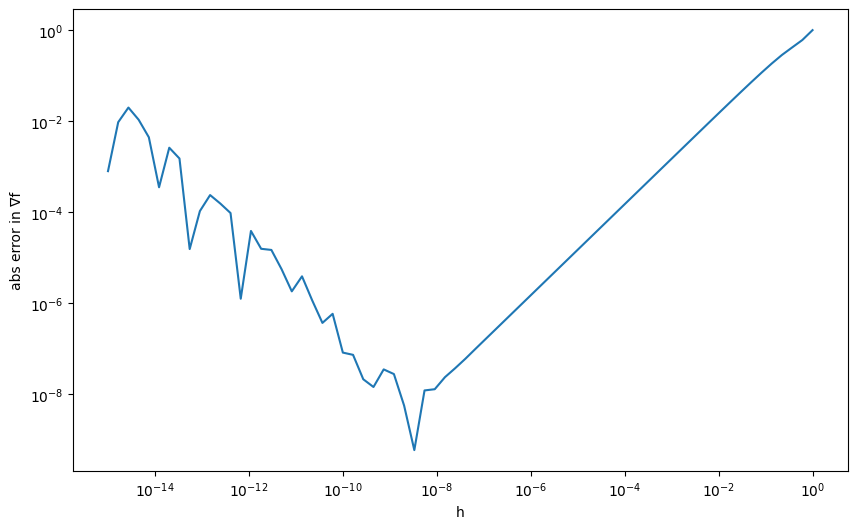

In [70]:
import matplotlib.pyplot as plt

# Analytical gradient
df = lambda x: np.array([2 * x[0], 3 * x[1] ** 2])

def plot_fd_err(f, df, x0):
    x = []
    y = []
    dfdx = df(x0)
    for h in np.logspace(-15, 0, 70):
        approx_dfdx = forward_difference(f, x0, h=h)
        x.append(h)
        y.append(max(abs(dfdx - approx_dfdx)))
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(x, y)
    ax.set_xlabel("h")
    ax.set_ylabel("abs error in ∇f")
    return ax
plot_fd_err(f, df, [0.5, -0.5]);

When we have a less smooth function, choosing $\delta$ is even more difficult and important!

Also, note that in order to do a finite difference approximation of the gradient we needed N+1 function calls, where $N$ is the number of elements in $x$!

# [Automatic Differentiation](https://docs.pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

**Automatic differentiation (autograd)** is a technique that lets a computer **compute exact derivatives automatically** by tracking how a result was computed.


Autograd computes derivatives exactly (up to floating-point precision) — not approximately.


Operations on tensors with `requires_grad=True`. Calling `.backward()` applies the chain rule through the graph and gradients are stored in the `.grad` attribute.

In [71]:
# Create tensor with gradient tracking
x = torch.tensor([3.0], requires_grad=True)

# Forward pass
y = x**2         # Pytorch knows dy = 2x dx
z = 3 * y + 1.   # Pytorch knows dz = 3 dy
print(f"z = {z.item()}")

# Backward pass (Pytorch uses chain rule dz/dx = dz/dy dy/dx)
z.backward() 

# Check gradient
print(f"dz/dx at x=23: {x.grad.item()}")

z = 28.0
dz/dx at x=23: 18.0


# Problem 1: Tensors and Automatic Differentiation

PyTorch tensors are similar to NumPy arrays but can run on GPUs and
support automatic differentiation. In this problem, you will explore
tensor operations and PyTorch’s autograd system.

**(1a)** Create the following tensors and perform the specified
operations:

1.  Create a tensor `a` containing the values \[1.0, 2.0, 3.0, 4.0,
    5.0\]
2.  Create a 3×3 tensor `B` filled with ones
3.  Reshape `a` to a 5×1 column vector
4.  Compute the element-wise square of `a`
5.  Compute the matrix product of `B` with itself

**Solution:**

In [72]:
# 1. Create tensor a
a = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])
print(f"a = {a}")

# 2. Create 3x3 tensor of ones
B = torch.ones(3, 3)
print(f"B = \n{B}")

# 3. Reshape a to column vector
a_col = a.view(5, 1)  # or a.reshape(5, 1)
print(f"a reshaped = \n{a_col}")

# 4. Element-wise square
a_squared = a ** 2  # or torch.square(a)
print(f"a squared = {a_squared}")

# 5. Matrix product
B_squared = B @ B  # or torch.mm(B, B)
print(f"B @ B = \n{B_squared}")

a = tensor([1., 2., 3., 4., 5.])
B = 
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
a reshaped = 
tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.]])
a squared = tensor([ 1.,  4.,  9., 16., 25.])
B @ B = 
tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])


**(1b)** PyTorch’s automatic differentiation (autograd) computes
gradients automatically. Consider the function $f(x) = x^2 + 3x + 1$.

1.  Compute $\frac{df}{dx}$ analytically. What is its value at $x = 2$?
2.  Create a tensor `x = torch.tensor([2.0], requires_grad=True)` and
    compute `y = x**2 + 3*x + 1`
3.  Call `y.backward()` to compute the gradient, then print `x.grad`
4.  Verify that PyTorch’s gradient matches your analytical result

**Solution:**

Analytically: $\frac{df}{dx} = 2x + 3$. At $x = 2$:
$\frac{df}{dx} = 2(2) + 3 = 7$.

In [73]:
# Create tensor with gradient tracking
x = torch.tensor([2.0], requires_grad=True)

# Forward pass
y = x**2 + 3*x + 1
print(f"y = {y.item()}")

# Backward pass (compute gradients)
y.backward()

# Check gradient
print(f"dy/dx at x=2: {x.grad.item()}")

y = 11.0
dy/dx at x=2: 7.0


The gradient computed by PyTorch (7.0) matches our analytical result.

**(1c)** Consider the function $g(x, y) = x^2 y + y^3$.

1.  Compute $\frac{\partial g}{\partial x}$ and
    $\frac{\partial g}{\partial y}$ analytically
2.  Use PyTorch to compute both partial derivatives at $(x, y) = (1, 2)$
3.  Verify the results match

**Solution:**

Analytically:

-   $\frac{\partial g}{\partial x} = 2xy$. At $(1, 2)$: $2(1)(2) = 4$
-   $\frac{\partial g}{\partial y} = x^2 + 3y^2$. At $(1, 2)$:
    $1 + 3(4) = 13$

In [74]:
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)

g = x**2 * y + y**3
g.backward()

print(f"dg/dx at (1,2): {x.grad.item()} (analytical: {2*1*2})")
print(f"dg/dy at (1,2): {y.grad.item()} (analytical: {1 + 3*4})")

dg/dx at (1,2): 4.0 (analytical: 4)
dg/dy at (1,2): 13.0 (analytical: 13)


**Note:** The `.grad` attribute stores the gradient of whatever tensor
you call `.backward()` on. If we compose functions, PyTorch applies the
chain rule automatically:

In [75]:
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([2.0], requires_grad=True)

g = x**2 * y + y**3
h = g**2  # h is a function of g

h.backward()

# x.grad now contains dh/dx = (dh/dg) * (dg/dx)
# dh/dg = 2g = 2(1*2 + 8) = 20
# dg/dx = 2xy = 4
# dh/dx = 20 * 4 = 80
print(f"dh/dx at (1,2): {x.grad.item()} (analytical: {2*(1*2 + 8) * 2*1*2})")

dh/dx at (1,2): 80.0 (analytical: 80)


# Stochastic Gradient Descent (SGD): Mathematical Intuition

We want to minimize an objective (loss) function
$$
\min_{\theta \in \mathbb{R}^d} \; f(\theta).
$$

In supervised learning with dataset $\{(x_i,y_i)\}_{i=1}^N$, the objective typically has the **finite-sum** form
$$
f(\theta) \;=\; \frac{1}{N}\sum_{i=1}^N \ell_i(\theta),
\quad\text{where}\quad
\ell_i(\theta) := \ell(\theta; x_i,y_i).
$$

### The optimal step size (motivates gradient descent)

Assume $f$ is differentiable. Consider moving from $\theta$ to $\theta'=\theta+\Delta$.
A second-order Taylor approximation around $\theta$ is
$$
f(\theta+\Delta)\;\approx\; f(\theta) + \nabla f(\theta)^\top \Delta + \frac{1}{2}\Delta^\top H(\theta)\Delta.
$$

### Steepest descent direction from first-order model
If we ignore the Hessian term (first-order approximation),
$$
f(\theta+\Delta)\approx f(\theta) + \nabla f(\theta)^\top \Delta.
$$
To decrease $f$, we want $\nabla f(\theta)^\top \Delta < 0$.

If we constrain the step length $\|\Delta\|_2 \le \varepsilon$, the direction that gives the largest decrease solves:
$$
\min_{\|\Delta\|\le \varepsilon}\;\nabla f(\theta)^\top \Delta.
$$
The solution is
$$
\Delta^\star = -\varepsilon \frac{\nabla f(\theta)}{\|\nabla f(\theta)\|_2}.
$$
So the **negative gradient** is the direction of steepest descent.

**Fun fact!** Take a direction $d$ and step size $\alpha>0$:
$$
\theta' = \theta + \alpha d.
$$

If we choose the steepest descent direction $d = -\nabla f(\theta)$, then minimizing this quadratic approximation over $\alpha$ gives Newton's method, which depends on the Hessian matrix, which is expansive to 

**GD uses a scalar learning rate $\eta$ as an approximation**:

$$
\theta_{t+1} = \theta_t - \eta \nabla f(\theta_t).
$$

### Why gradient descent works？A guarantee for $L$-smooth functions

A clean guarantee comes from **smoothness**.

Assume $\nabla f$ is Lipschitz with constant $L$:
$$
\|\nabla f(u)-\nabla f(v)\|_2 \le L\|u-v\|_2.
$$
Then, it can be shown, for any $\eta>0$:
$$
f(\theta - \eta \nabla f(\theta))
\le
f(\theta) - \eta\|\nabla f(\theta)\|_2^2 + \frac{L}{2}\eta^2 \|\nabla f(\theta)\|_2^2
=
f(\theta) - \Big(\eta - \frac{L}{2}\eta^2\Big)\|\nabla f(\theta)\|_2^2.
$$

If $0<\eta<\frac{2}{L}$, the coefficient is positive, so each step decreases $f$ unless $\nabla f(\theta)=0$.




### GD vs SGD
For
$$
f(\theta)=\frac{1}{N}\sum_{i=1}^N \ell_i(\theta),
\qquad
\nabla f(\theta)=\frac{1}{N}\sum_{i=1}^N \nabla \ell_i(\theta),
$$
computing $\nabla f(\theta)$ costs $O(N)$ gradient evaluations each step. For large $N$, this is **expensive**.

Pick a random index $I \sim \text{Unif}\{1,\dots,N\}$ and define
$$
g(\theta) := \nabla \ell_I(\theta).
$$
Then
$$
\mathbb{E}[g(\theta)] = \mathbb{E}[\nabla \ell_I(\theta)]
= \frac{1}{N}\sum_{i=1}^N \nabla \ell_i(\theta)
= \nabla f(\theta).
$$
So $g(\theta)$ is an **unbiased** estimator of the true gradient, but has variance:
$$
\mathrm{Var}(g(\theta)) = \mathbb{E}\|g(\theta)-\nabla f(\theta)\|_2^2.
$$

With a mini-batch $B$ of size $m$ sampled i.i.d.,
$$
g_B(\theta) := \frac{1}{m}\sum_{i\in B}\nabla \ell_i(\theta),
\qquad
\mathbb{E}[g_B(\theta)]=\nabla f(\theta),
\qquad
\mathrm{Var}(g_B(\theta)) \propto \frac{1}{m}.
$$

**SGD** uses this noisy gradient:
$$
\theta_{t+1} = \theta_t - \eta_t\, g_t,
\quad\text{where}\quad
g_t \approx \nabla f(\theta_t).
$$`

# Problem 2: Linear Regression in PyTorch

In this problem, you will implement linear regression using PyTorch’s
neural network modules and optimizers.

In [76]:
import torch.nn as nn
import torch.optim as optim

In [77]:
# Generate synthetic data for linear regression
n_samples = 100
true_weight = 3.5
true_bias = 1.2

X = torch.randn(n_samples, 1)
y = true_weight * X + true_bias + 0.3 * torch.randn(n_samples, 1)

**(2a)** Visualize the data, then create a linear regression model using
`nn.Linear`. This module implements $\hat{y} = Wx + b$ where $W$
(weight) and $b$ (bias) are learnable parameters.

1.  Create a model: `model = nn.Linear(in_features=1, out_features=1)`
2.  Print the initial (random) weight and bias using `model.weight` and
    `model.bias`
3.  Make predictions on `X` using `model(X)` and plot them alongside the
    true data

**Solution:**

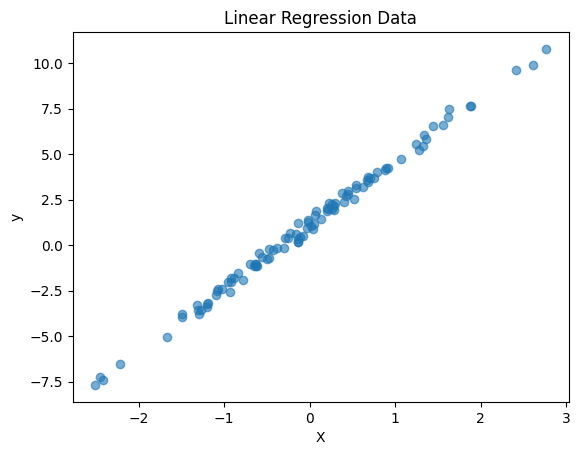

Initial weight: -0.5232
Initial bias: 0.1514


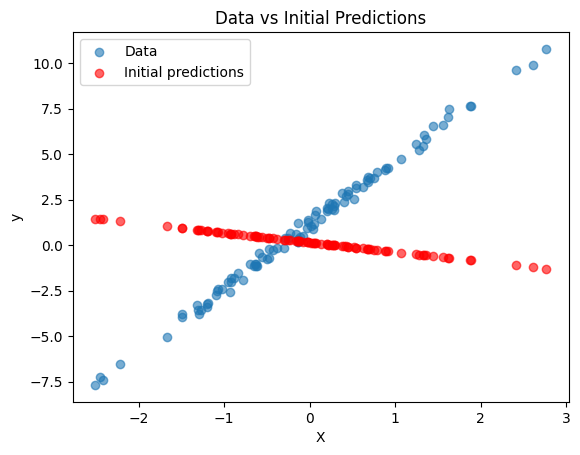

In [78]:
# Visualize the data
plt.scatter(X.numpy(), y.numpy(), alpha=0.6)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Data')
plt.show()

# Create linear model
model = nn.Linear(in_features=1, out_features=1)

# Print initial parameters
print(f"Initial weight: {model.weight.item():.4f}")
print(f"Initial bias: {model.bias.item():.4f}")

# Make predictions
with torch.no_grad():   # Context manager: Run this code without tracking operations for autograd, faster and uses less memory
    y_pred_init = model(X)

# Plot
plt.scatter(X.numpy(), y.numpy(), alpha=0.6, label='Data')
plt.scatter(X.numpy(), y_pred_init.numpy(), alpha=0.6, label='Initial predictions', color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Data vs Initial Predictions')
plt.show()

**(2b)** Implement the training loop to fit the model. Use:

-   Loss function: `nn.MSELoss()`
-   Optimizer: `optim.SGD(model.parameters(), lr=0.1)`
-   Train for 100 epochs

The training loop should follow this pattern:

``` python
for epoch in range(n_epochs):
    # 1. Forward pass: compute predictions
    # 2. Compute loss
    # 3. Zero gradients: optimizer.zero_grad()
    # 4. Backward pass: loss.backward()
    # 5. Update parameters: optimizer.step()
```

Store the loss at each epoch and plot the loss curve.

**Solution:**

Epoch 20: Loss = 0.0587
Epoch 40: Loss = 0.0577
Epoch 60: Loss = 0.0577
Epoch 80: Loss = 0.0577
Epoch 100: Loss = 0.0577


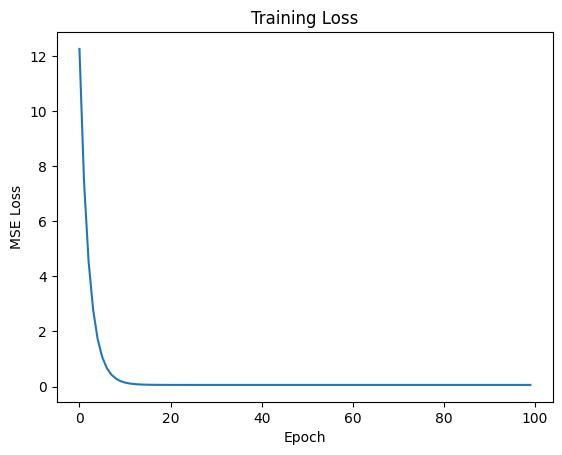

In [79]:
# Reset model
model = nn.Linear(1, 1)     # 1 input, 1 output

# Loss and optimizer
criterion = nn.MSELoss()    # (y_pred - y)^2
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Initialization

# Training loop
n_epochs = 100
losses = []

for epoch in range(n_epochs):
    # Forward pass
    y_pred = model(X)       # (computes predictions)
    
    # Compute loss
    loss = criterion(y_pred, y)
    losses.append(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()    # Reset stored gradients from the previous epoch
    
    # Backward pass
    loss.backward()          # computes the gradient
    
    # Update parameters
    optimizer.step()         # Updates the model parameters
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

# Plot loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

**(2c)** After training:

1.  Print the learned weight and bias
2.  Compute the analytical OLS solution:
    $\hat{\beta} = (X^\top X)^{-1} X^\top y$ (hint: add a column of ones
    for the intercept)
3.  Compare the SGD estimates to both the OLS solution and the true
    values (3.5 and 1.2)
4.  Plot the learned regression line alongside the data

**Solution:**

Method           Weight       Bias
----------------------------------
True             3.5000     1.2000
OLS              3.5034     1.1556
SGD              3.5034     1.1556


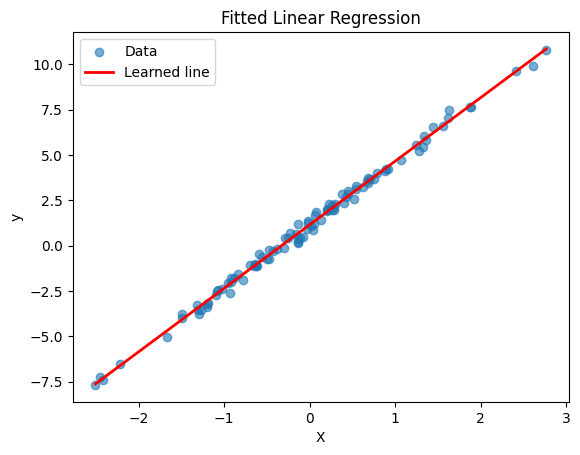

In [80]:
# Compute analytical OLS solution
X_with_intercept = torch.cat([torch.ones(n_samples, 1), X], dim=1)
beta_ols = torch.linalg.lstsq(X_with_intercept, y).solution
ols_bias, ols_weight = beta_ols[0].item(), beta_ols[1].item()

# Print comparison
print(f"{'Method':<12} {'Weight':>10} {'Bias':>10}")
print("-" * 34)
print(f"{'True':<12} {true_weight:>10.4f} {true_bias:>10.4f}")
print(f"{'OLS':<12} {ols_weight:>10.4f} {ols_bias:>10.4f}")
print(f"{'SGD':<12} {model.weight.item():>10.4f} {model.bias.item():>10.4f}")

# Plot regression line
with torch.no_grad():
    y_pred_final = model(X)

plt.scatter(X.numpy(), y.numpy(), alpha=0.6, label='Data')
# Sort for line plot
sort_idx = X.squeeze().argsort()
plt.plot(X[sort_idx].numpy(), y_pred_final[sort_idx].numpy(), 'r-', linewidth=2, label='Learned line')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Fitted Linear Regression')
plt.show()

The SGD solution should closely match the OLS solution. Both may differ
slightly from the true values due to noise in the data.

**(2d)** Compare SGD with the Adam optimizer (`optim.Adam`). Retrain the
model with both optimizers and plot their loss curves. Which converges
faster?

**Solution:**

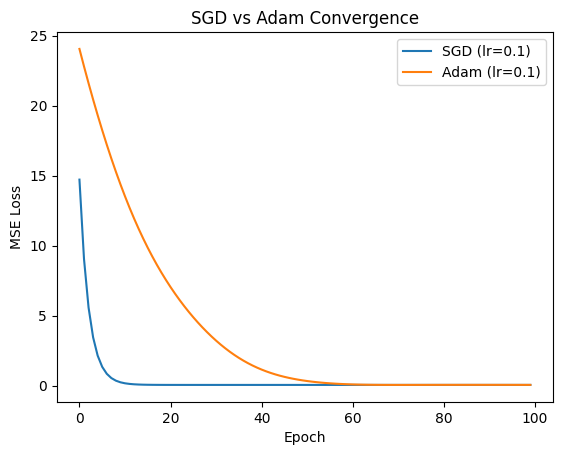

In [81]:
# Compare SGD vs Adam
def train_model(optimizer_class, lr, n_epochs=100):
    model = nn.Linear(1, 1)
    criterion = nn.MSELoss()
    optimizer = optimizer_class(model.parameters(), lr=lr)
    
    losses = []
    for epoch in range(n_epochs):
        y_pred = model(X)
        loss = criterion(y_pred, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return losses

# Train with both optimizers
losses_sgd = train_model(optim.SGD, lr=0.1)
losses_adam = train_model(optim.Adam, lr=0.1)

# Plot comparison
plt.plot(losses_sgd, label='SGD (lr=0.1)')
plt.plot(losses_adam, label='Adam (lr=0.1)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('SGD vs Adam Convergence')
plt.show()


## Adamin (Adaptive moments)

Let $g_t$ be the stochastic gradient at step $t$.

### First moment (momentum-like)
Adam keeps an exponential moving average of gradients:
$$
m_t = \beta_1 m_{t-1} + (1-\beta_1)\, g_t,
$$
where $\beta_1 \in [0,1)$ (typical: $\beta_1=0.9$).

The recursion
$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
$$
is an exponential moving average:
$$
m_t \approx (1-\beta_1)\sum_{k=0}^{t} \beta_1^{t-k} g_k.
$$

So $m_t$ is a weighted average of recent gradients, making the direction less noisy than raw $g_t$.


### Second moment (RMS-like)
Adam also keeps an exponential moving average of squared gradients (coordinatewise square):
$$
v_t = \beta_2 v_{t-1} + (1-\beta_2)\, (g_t \odot g_t),
$$
where $\beta_2 \in [0,1)$ and $\odot$ is elementwise product.

So coordinatewise:
$$
(v_t)_i = \beta_2 (v_{t-1})_i + (1-\beta_2)\, (g_t)_i^2.
$$

So $v_t$ measures “how large gradients usually are”


### Bias correction (important detail)
Because $m_0=0$ and $v_0=0$, early estimates are biased toward zero. Adam corrects this:
$$
\hat m_t = \frac{m_t}{1-\beta_1^t}, 
\qquad
\hat v_t = \frac{v_t}{1-\beta_2^t}.
$$

Because $m_0=0$,
$$
m_1 = (1-\beta_1)g_1,
$$
so $m_1$ is systematically smaller than $g_1$ in magnitude.

In expectation (assuming stationary gradient mean $\mathbb{E}[g_t]=\mu_g$):
$$
\mathbb{E}[m_t] = (1-\beta_1^t)\mu_g.
$$

Thus dividing by $(1-\beta_1^t)$ yields an unbiased estimate of $\mu_g$:
$$
\mathbb{E}[\hat m_t] = \mu_g.
$$

Analogous reasoning holds for $v_t$.

### Parameter update
Adam uses a coordinatewise learning rate:
$$
\theta_{t+1}
= \theta_t - \alpha \, \frac{\hat m_t}{\sqrt{\hat v_t} + \varepsilon}.
$$

Coordinatewise, for coordinate $i$:
$$
(\theta_{t+1})_i
=
(\theta_t)_i - \alpha \, \frac{(\hat m_t)_i}{\sqrt{(\hat v_t)_i} + \varepsilon}.
$$


Adam typically converges faster because it adapts the learning rate for
each parameter.

# Problem 3: Multi-Layer Perceptron on MNIST

In this problem, you will build a multi-layer perceptron (MLP) to
classify handwritten digits from the MNIST dataset.

# [Dataset and DataLoaders](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

When training a model, we *can* work directly with tensors, but this approach does not scale well and becomes hard to maintain in real-world projects.

If all data is loaded into tensors, the data must fit in memory (CPU RAM or GPU VRAM). For large datasets, this is often not feasible.

Raw tensors also do not provide built-in functionality such as:
- batching
- shuffling data at every epoch
- efficient and parallel data loading

In practice, real-world datasets are very large. They are usually stored on disk and loaded **on demand** during training. This requires fast data access and reshuffling at each epoch.

To handle this cleanly and efficiently, PyTorch provides two data primitives:

- **`torch.utils.data.Dataset`**
- **`torch.utils.data.DataLoader`**

A **Dataset** defines how to access the data. Given an index, it returns **one data sample and its corresponding label**, typically as `(input, label)`. The data may be pre-loaded in memory or loaded from disk on demand.

A **DataLoader** wraps a Dataset and provides an iterable that returns **mini-batches** of data, with optional **shuffling** and **efficient loading**.



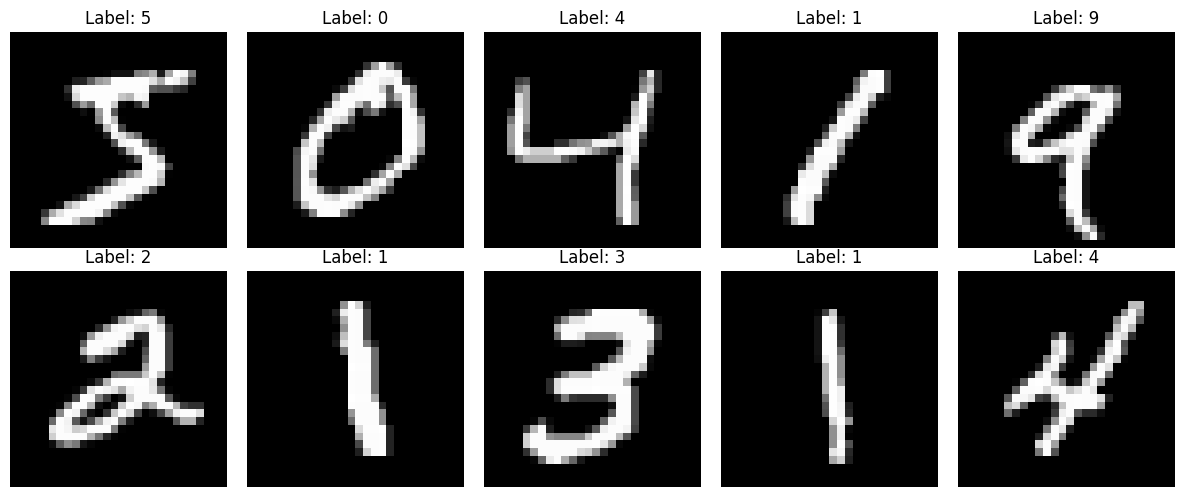

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


In [82]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load MNIST dataset
transform = transforms.Compose([                # In PyTorch, transforms are composable preprocessing/augmentation functions applied to data 
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Visualize some examples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")

In [83]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [84]:
train_dataset.data.size()

torch.Size([60000, 28, 28])

In [85]:
it = iter(train_loader)
next(it)


[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
       

In [86]:
len(next(it)[1])

64

**(3a)** Build an MLP with the following architecture using
`nn.Sequential`:

-   Input: 784 features (28×28 flattened image)
-   Hidden layer 1: 256 units, ReLU activation
-   Hidden layer 2: 128 units, ReLU activation
-   Output: 10 units (one per digit class)

Print the model architecture and count the total number of parameters.

**Solution:**

`nn.Sequential` composes modules $f_1,\dots,f_L$ and applies them in order: let $h^{(0)}=x$ and define
$$
h^{(\ell)} = f_\ell\!\left(h^{(\ell-1)}\right)\quad (\ell=1,\dots,L),
$$
so
$$
\mathrm{Sequential}(x)=h^{(L)}=f_L\!\left(f_{L-1}\!\left(\cdots f_1(x)\cdots\right)\right).
$$

For the MLP with input $x\in\mathbb{R}^{B\times 1\times 28\times 28}$, the modules are:
- $f_1=\mathrm{Flatten}$: $h^{(1)}\in\mathbb{R}^{B\times 784}$
- $f_2(z)=zW_1^\top+b_1$, $W_1\in\mathbb{R}^{256\times 784}$, $b_1\in\mathbb{R}^{256}$: $h^{(2)}\in\mathbb{R}^{B\times 256}$
- $f_3(z)=\max(0,z)$: $h^{(3)}\in\mathbb{R}^{B\times 256}$
- $f_4(z)=zW_2^\top+b_2$, $W_2\in\mathbb{R}^{128\times 256}$, $b_2\in\mathbb{R}^{128}$: $h^{(4)}\in\mathbb{R}^{B\times 128}$
- $f_5(z)=\max(0,z)$: $h^{(5)}\in\mathbb{R}^{B\times 128}$
- $f_6(z)=zW_3^\top+b_3$, $W_3\in\mathbb{R}^{10\times 128}$, $b_3\in\mathbb{R}^{10}$: $h^{(6)}=\mathrm{logits}\in\mathbb{R}^{B\times 10}$


In [87]:
# Define the MLP
model = nn.Sequential(
    nn.Flatten(),  # Flatten 28x28 to 784
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=10, bias=True)
)

Total parameters: 235,146
Trainable parameters: 235,146


**(3b)** Train the model:

-   Loss function: `nn.CrossEntropyLoss()` (combines softmax and
    negative log-likelihood)
-   Optimizer: `optim.Adam(model.parameters(), lr=0.001)`
-   Train for 5 epochs

For each epoch, compute and print:

1.  Average training loss
2.  Training accuracy
3.  Test accuracy

Use this helper function to compute accuracy:

In [88]:
def compute_accuracy(model, data_loader):
    model.eval()  # Sets evaluation mode (disables dropout/batchnorm training behavior)
    correct = 0
    total = 0
    with torch.no_grad():    # Disable gradient tracking to reduce memory usage and speed up inference
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device) # Move tensors to the same device as the model (CPU/GPU)
            outputs = model(images)   # compute logits/scores for each class
            _, predicted = torch.max(outputs, 1)   #  Get class indices with the highest "probability"
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Add correct predictions
    return 100 * correct / total

**Solution:**

In [89]:
# Move model to device
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()   # Min CE <=> Max p(true class)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 5
train_losses = []
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    model.train()  # Sets training mode (affects dropout/batchnorm), doesn't run training
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Compute metrics
    avg_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    test_acc = compute_accuracy(model, test_loader)
    
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f"Epoch {epoch+1}/{n_epochs}: Loss={avg_loss:.4f}, Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%")

Epoch 1/5: Loss=0.2272, Train Acc=93.20%, Test Acc=95.81%
Epoch 2/5: Loss=0.0927, Train Acc=97.16%, Test Acc=96.53%
Epoch 3/5: Loss=0.0655, Train Acc=97.92%, Test Acc=97.50%
Epoch 4/5: Loss=0.0503, Train Acc=98.36%, Test Acc=97.15%
Epoch 5/5: Loss=0.0387, Train Acc=98.74%, Test Acc=97.79%


**(3c)** Evaluate and visualize:

1.  Plot the training loss and accuracies over epochs
2.  Display 10 test images with their predicted labels. Mark incorrect
    predictions in red.
3.  What test accuracy did you achieve? How does this compare to random
    guessing (10%)?

**Solution:**

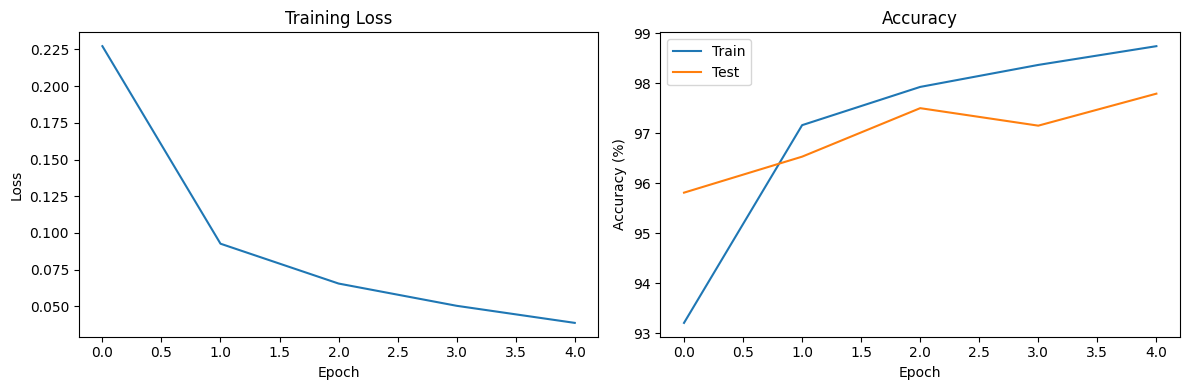

In [90]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')

axes[1].plot(train_accs, label='Train')
axes[1].plot(test_accs, label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

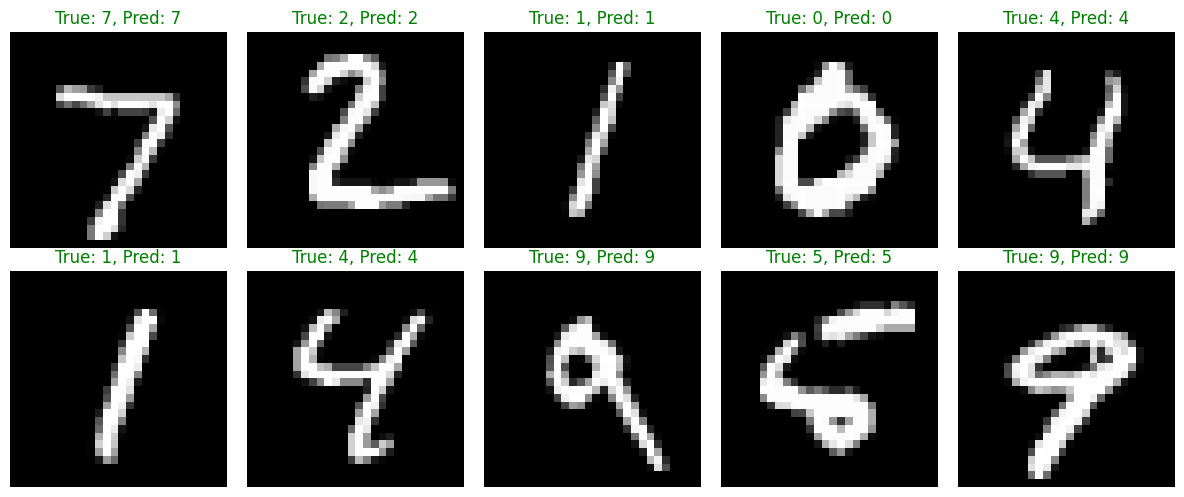


Final test accuracy: 97.79%
Random guessing would give: 10%
Improvement over random: 87.79 percentage points


In [91]:
# Visualize predictions
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

# Get some test images
test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images[:10], test_labels[:10]

with torch.no_grad():
    outputs = model(test_images.to(device))
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.cpu()

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i].squeeze(), cmap='gray')
    true_label = test_labels[i].item()
    pred_label = predictions[i].item()
    
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nFinal test accuracy: {test_accs[-1]:.2f}%")
print(f"Random guessing would give: 10%")
print(f"Improvement over random: {test_accs[-1] - 10:.2f} percentage points")